File to train the deep learning model on new data

In [10]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode 

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import os
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import random

In [12]:
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off')

In [13]:
image_training_dir = "Images/pool/training/images/"
image_testing_dir = "Images/pool/testing/images/"
annotation_training_dir = "Images/pool/training/labels/"
annotation_testing_dir = "Images/pool/testing/labels/"
annotation_training_files = ["000002764.xml", "000002041.xml", "000000186.xml"]

In [14]:
# Parse XML file
def parse_xml(img_dir, file):
    tree = ET.parse(file)
    root = tree.getroot()

    file_dict = {}

    file_dict["file_name"] = os.path.join(img_dir.replace('labels', 'images'), root.find('filename').text)
    file_dict["height"] = int(root.find("size/height").text)
    file_dict["width"] = int(root.find("size/width").text)

    list_with_all_boxes = []
    for boxes in root.iter('object'):
        
        
        ymin, xmin, ymax, xmax = None, None, None, None
        
        ymin = round(float(boxes.find("bndbox/ymin").text))
        xmin = round(float(boxes.find("bndbox/xmin").text))
        ymax = round(float(boxes.find("bndbox/ymax").text))
        xmax = round(float(boxes.find("bndbox/xmax").text))

        obj = {
            "bbox": [xmin, ymin, xmax, ymax],
            "bbox_mode": BoxMode.XYXY_ABS,
            "category_id": 0,
        }
        list_with_all_boxes.append(obj)
    file_dict["annotations"] = list_with_all_boxes
    return file_dict

def parse_dir_xml(annotation_folder):
    fichiers = [f for f in os.listdir(annotation_folder) if os.path.isfile(os.path.join(annotation_folder, f))]
    dataset_dicts = []

    for data in fichiers:
        record = parse_xml(annotation_folder ,os.path.join(annotation_folder, data))
        dataset_dicts.append(record)
    return dataset_dicts

# Visualize image with bounding boxes
def visualize_image(image_folder, annotation_folder, annotation_file):
    data = parse_xml(annotation_folder, os.path.join(annotation_folder, annotation_file))

    img = cv2.imread(data["file_name"])

    for box in data["annotations"]:
        cv2.rectangle(img, (box["bbox"][0], box["bbox"][1]), (box["bbox"][2], box["bbox"][3]), (0, 255, 0), 2)
    
    cv2_imshow(img)

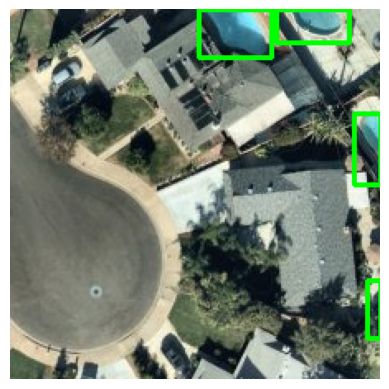

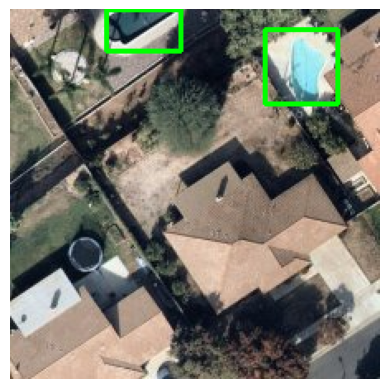

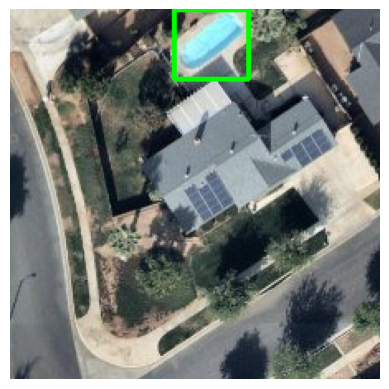

In [15]:
for ann_file in annotation_training_files:
    visualize_image(image_training_dir, annotation_training_dir, ann_file)

In [16]:
for d in ["training", "testing"]:
    DatasetCatalog.register("pool_" + d, lambda d=d: parse_dir_xml("Images/pool/" + d + "/labels/"))
    MetadataCatalog.get("pool_" + d).set(thing_classes=["pool"])

pool_metadata = MetadataCatalog.get("pool_training")

In [17]:
DatasetCatalog.get("pool_testing")

[{'file_name': 'Images/pool/testing/images/000000698.jpg',
  'height': 224,
  'width': 224,
  'annotations': [{'bbox': [210, 204, 223, 224],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'Images/pool/testing/images/000000524.jpg',
  'height': 224,
  'width': 224,
  'annotations': [{'bbox': [77, 191, 128, 214],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'Images/pool/testing/images/000000084.jpg',
  'height': 224,
  'width': 224,
  'annotations': [{'bbox': [1, 182, 20, 220],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'Images/pool/testing/images/000000075.jpg',
  'height': 224,
  'width': 224,
  'annotations': [{'bbox': [1, 91, 18, 116],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'category_id': 0}]},
 {'file_name': 'Images/pool/testing/images/000000642.jpg',
  'height': 224,
  'width': 224,
  'annotations': [{'bbox': [1, 119, 48, 143],
    'bbox_mode': <BoxMode.XYXY_ABS: 0>,
    'c

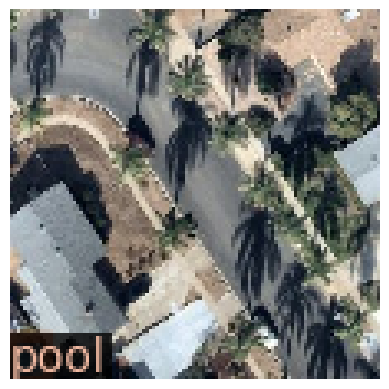

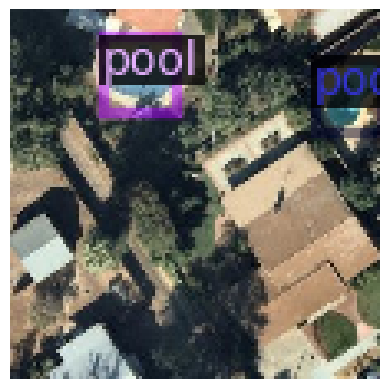

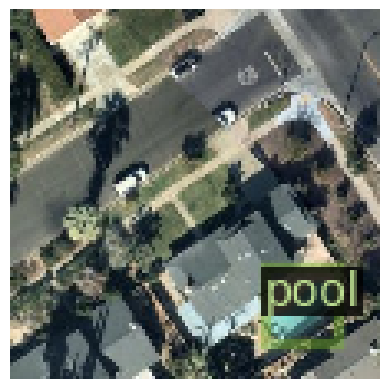

In [18]:
dataset_dicts = parse_dir_xml(annotation_training_dir)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pool_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [46]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda"

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml"))
cfg.DATASETS.TRAIN = ("pool_training")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 600    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/11 15:42:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

model_final_68d202.pkl: 663MB [00:58, 11.4MB/s]                               
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box

[11/11 15:43:31 d2.engine.train_loop]: Starting training from iteration 0
[11/11 15:43:35 d2.utils.events]:  eta: 0:01:53  iter: 19  total_loss: 1.319  loss_cls: 0.7834  loss_box_reg: 0.3921  loss_rpn_cls: 0.1469  loss_rpn_loc: 0.006171    time: 0.1979  last_time: 0.2077  data_time: 0.0058  last_data_time: 0.0027   lr: 8.1588e-06  max_mem: 3016M
[11/11 15:43:39 d2.utils.events]:  eta: 0:01:48  iter: 39  total_loss: 1.185  loss_cls: 0.6412  loss_box_reg: 0.398  loss_rpn_cls: 0.1214  loss_rpn_loc: 0.006764    time: 0.1953  last_time: 0.1707  data_time: 0.0029  last_data_time: 0.0032   lr: 1.6484e-05  max_mem: 3019M
[11/11 15:43:43 d2.utils.events]:  eta: 0:01:44  iter: 59  total_loss: 0.9945  loss_cls: 0.4605  loss_box_reg: 0.3708  loss_rpn_cls: 0.09902  loss_rpn_loc: 0.01115    time: 0.1942  last_time: 0.1901  data_time: 0.0027  last_data_time: 0.0026   lr: 2.4809e-05  max_mem: 3019M
[11/11 15:43:47 d2.utils.events]:  eta: 0:01:40  iter: 79  total_loss: 0.7873  loss_cls: 0.3483  loss_bo

In [47]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 31508), started 3:41:14 ago. (Use '!kill 31508' to kill it.)

In [48]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

[11/11 15:45:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


Images/pool/testing/images/000000086.jpg
Images/pool/testing/images/000002440.jpg
Images/pool/testing/images/000002598.jpg
Images/pool/testing/images/000000442.jpg


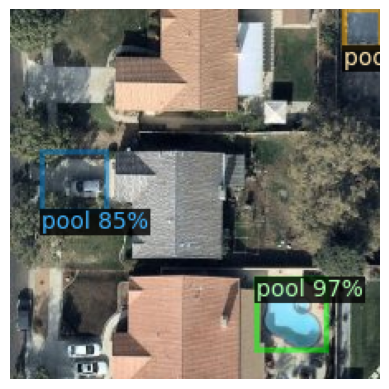

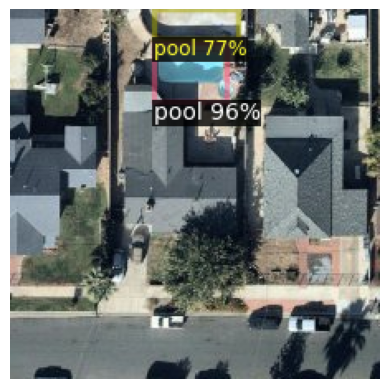

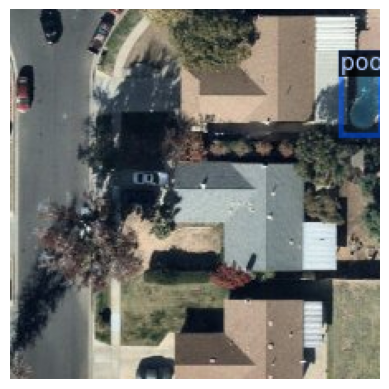

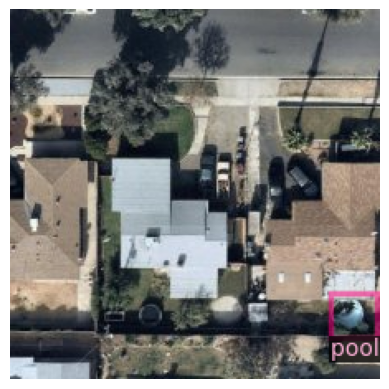

In [49]:
from detectron2.utils.visualizer import ColorMode
# from detectron2.utils.visualizer import ColorMode
dataset_dicts2 = parse_dir_xml("Images/pool/testing/labels/")
dataset_dicts2
for d in random.sample(dataset_dicts2, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=pool_metadata, 
                   scale=1, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(d["file_name"])
    cv2_imshow(out.get_image()[:, :, ::-1])


In [56]:
im = cv2.imread("Images/pool/testing/imagestest/img_20231111153246.png")
n, m = random.randint(1,6), random.randint(1,6)
size = 224
output = predictor(im[n*size:(n+1)*size,m*size:(m+1)*size,:])
print(output)

{'instances': Instances(num_instances=4, image_height=224, image_width=224, fields=[pred_boxes: Boxes(tensor([[ 67.4834, 165.3518, 113.3131, 205.4264],
        [143.2568, 169.3415, 186.0469, 206.3084],
        [  1.3352, 168.6574,  29.9539, 196.0024],
        [203.8853,  23.9259, 221.8353,  54.4619]], device='cuda:0')), scores: tensor([0.9867, 0.9864, 0.8438, 0.7850], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0], device='cuda:0')])}


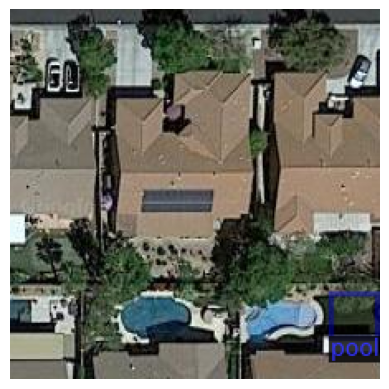

In [57]:
v = Visualizer(im[n*size:(n+1)*size,m*size:(m+1)*size, ::-1],
                metadata=pool_metadata, 
                scale=1, 
                instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:,:, ::-1])